# Models

This notebook will demonstrate the basic features of AutoMPC for system ID modeling and model evaluation.

## Set-Up

As before, we will generate our trajectories using the benchmark module.

In [1]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()


# Get system and task specification
system = benchmark.system
task   = benchmark.task

# Generate benchmark dataset
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

Loading AutoMPC...
Cannot import SnoptWrapper
Cannot import KnitroSolver, make sure its Python interface is installed
Finished loading AutoMPC
running build_ext


## Models

AutoMPC provides a variety of sytem ID models which can be used to learn the sytem dynamics.  Here, we train an MLP model to predict the cartpole dynamics.

In [2]:
from autompc.sysid import MLP

model = MLP(system, n_hidden_layers=2, hidden_size_1=128, hidden_size_2=128, n_train_iters=50,
               nonlintype="relu")

model.train(trajs)

use_cuda=True
MLP Using Cuda
hidden_sizes= [128, 128]
100%|██████████| 50/50 [02:49<00:00,  3.38s/it]


Now that we have trained our model, we can use it to make predictions.  Let's try predicting the next state from one of our training trajectories.  We first compute the model state at a certain point in the trajectory

In [3]:
traj = trajs[0]
model_state = model.traj_to_state(traj[:100])

The model state contains the information the model needs to predict the next time step.  The model state always begins with the most recent observation.  For MLP, the model state is actually the same as the most recent observation, but this is not necessarily the case.  For example, the ARX model state also contains a history of observations for several time steps.

Now, we can predict the next state

In [4]:
pred_state = model.pred(model_state, traj[99].ctrl)
pred_state

array([ 2.41286448,  4.03496465, 27.24861947,  7.65636714])

Compare this to the true observation

In [5]:
traj[100].obs

array([ 2.41170398,  4.04120632, 27.2465825 ,  7.66062691])

For differentiable models, we can also get the gradient of the
model prediction

In [6]:
pred_state, state_jac, ctrl_jac = model.pred_diff(model_state, traj[99].ctrl)
state_jac

array([[ 9.98693111e-01,  5.00903701e-02,  7.38808326e-06,
         8.68121224e-06],
       [ 5.14443615e-01,  9.49758929e-01,  7.57387242e-06,
        -4.71907839e-04],
       [ 2.74026899e-03,  2.61244824e-04,  1.00000587e+00,
         5.00787339e-02],
       [ 7.78636272e-03, -9.10321627e-04,  1.06090435e-04,
         9.99237129e-01]])

## Graphing Model Accuracy

Let's train another, much smaller MLP model

In [7]:
from autompc.sysid import MLP

model2 = MLP(system, n_hidden_layers=1, hidden_size_1=32, n_train_iters=50,
               nonlintype="relu")

model2.train(trajs)

use_cuda=True
MLP Using Cuda
hidden_sizes= [32]
100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


Now, we'd like to compare this to our original model.  One convenient way to do this is by graphing the model prediction horizon over various prediction horizons.

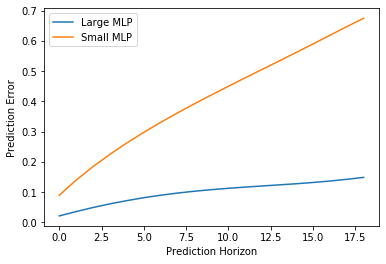

In [11]:
import matplotlib.pyplot as plt
from autompc.graphs.kstep_graph import KstepPredAccGraph

graph = KstepPredAccGraph(system, trajs, kmax=20, metric="rmse")
graph.add_model(model, "Large MLP")
graph.add_model(model2, "Small MLP")

fig = plt.figure()
ax = fig.gca()
graph(fig, ax)
plt.show()